In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os import path
import pickle

In [3]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 100

In [4]:
def put_content(files, directory):
    for file_name in files:
        ids.append(int(file_name.replace(".txt", "").split("_")[0]))
        grades.append(0 if int(file_name.replace(".txt", "").split("_")[1]) < 5 else 1)
        texts.append(open(path.join(directory, file_name), 'r').read())

In [5]:
# Подготовка тренировочного набора
ids = []
grades = []
texts = []

train_neg_dir = "aclImdb/train/neg"
train_pos_dir = "aclImdb/train/pos"

train_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_neg_dir)))
train_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_pos_dir)))

put_content(train_neg_files, train_neg_dir)
put_content(train_pos_files, train_pos_dir)

train_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

train_df = train_df.iloc[np.random.permutation(len(train_df))].reset_index(drop=True)

In [6]:
# Подготовка тестового набора
ids = []
grades = []
texts = []

test_neg_dir = "aclImdb/test/neg"
test_pos_dir = "aclImdb/test/pos"

test_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_neg_dir)))
test_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_pos_dir)))

put_content(test_neg_files, test_neg_dir)
put_content(test_pos_files, test_pos_dir)

test_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

test_df = test_df.iloc[np.random.permutation(len(test_df))].reset_index(drop=True)

In [7]:
# Создание токенайзера
tokenizer = Tokenizer(num_words=num_words)

In [8]:
# Тренировка токенайзера
tokenizer.fit_on_texts(train_df['text'])

In [9]:
# Сохранение токенайзера
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# Преобразование текста в последовательности чисел
sequences = tokenizer.texts_to_sequences(train_df['text'])

In [11]:
# Ограничить длину отзыва
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [11]:
# Сверточная нейронная сеть

In [12]:
# Создание самой модели
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_news_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
# Компиляция модели
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 250)           40250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 250)           312750    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 250)           312750    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 84, 250)           312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [14]:
# Сохренение модели
model.save('model_binary')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_binary/assets


In [15]:
# Создаем callback для сохранения нейронной сети на каждой эпохе,
    # если качество работы на проверочном наборе данных улучшилось.
# Сеть сохраняется в файл best_model.h5
model_binary_save_path = 'best_model_binary.h5'
checkpoint_callback = ModelCheckpoint(model_binary_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [12]:
# Правильные ответы
y_train = train_df['grade']

In [24]:
history = model.fit(x_train, 
                            y_train, 
                            epochs=3,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback])

Epoch 1/3
176/176 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5264
Epoch 00001: val_accuracy improved from -inf to 0.71400, saving model to best_model_binary.h5
176/176 [==============================] - 167s 950ms/step - loss: 0.6804 - accuracy: 0.5264 - val_loss: 0.5671 - val_accuracy: 0.7140
Epoch 2/3
176/176 [==============================] - ETA: 0s - loss: 0.4424 - accuracy: 0.7948
Epoch 00002: val_accuracy improved from 0.71400 to 0.82160, saving model to best_model_binary.h5
176/176 [==============================] - 161s 914ms/step - loss: 0.4424 - accuracy: 0.7948 - val_loss: 0.3908 - val_accuracy: 0.8216
Epoch 3/3
176/176 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8823
Epoch 00003: val_accuracy improved from 0.82160 to 0.84960, saving model to best_model_binary.h5
176/176 [==============================] - 158s 898ms/step - loss: 0.2830 - accuracy: 0.8823 - val_loss: 0.3540 - val_accuracy: 0.8496


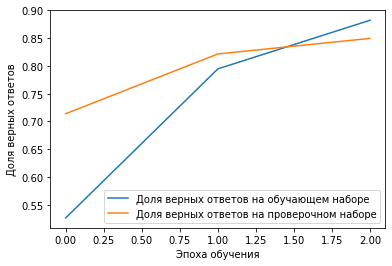

In [25]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [13]:
# Дополнительные домонстрационные модели

In [56]:
# Сеть LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(1, activation='sigmoid'))

In [57]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [58]:
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [60]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7425
Epoch 00001: val_accuracy improved from -inf to 0.85240, saving model to best_model_lstm.h5
176/176 [==============================] - 12s 66ms/step - loss: 0.5169 - accuracy: 0.7425 - val_loss: 0.3496 - val_accuracy: 0.8524
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8869
Epoch 00002: val_accuracy improved from 0.85240 to 0.86240, saving model to best_model_lstm.h5
176/176 [==============================] - 11s 64ms/step - loss: 0.2820 - accuracy: 0.8869 - val_loss: 0.3193 - val_accuracy: 0.8624
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9229
Epoch 00003: val_accuracy did not improve from 0.86240
176/176 [==============================] - 11s 62ms/step - loss: 0.2112 - accuracy: 0.9229 - val_loss: 0.3431 - val_accuracy: 0.8512
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 0.167

In [32]:
# Сеть GRU

In [44]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(1, activation='sigmoid'))

In [45]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [46]:
model_gru.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 322,417
Trainable params: 322,417
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [48]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7002
Epoch 00001: val_accuracy improved from -inf to 0.83800, saving model to best_model_gru.h5
176/176 [==============================] - 13s 74ms/step - loss: 0.5505 - accuracy: 0.7002 - val_loss: 0.3765 - val_accuracy: 0.8380
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8762
Epoch 00002: val_accuracy improved from 0.83800 to 0.84760, saving model to best_model_gru.h5
176/176 [==============================] - 13s 71ms/step - loss: 0.3032 - accuracy: 0.8762 - val_loss: 0.3437 - val_accuracy: 0.8476
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9144
Epoch 00003: val_accuracy improved from 0.84760 to 0.84920, saving model to best_model_gru.h5
176/176 [==============================] - 12s 69ms/step - loss: 0.2288 - accuracy: 0.9144 - val_loss: 0.3548 - val_accuracy: 0.8492
Epoch 4/5
176/176 [==================

In [50]:
# Тестирование работы

In [51]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [52]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [53]:
# Правильные ответы на тестовом наборе
y_test = test_df['grade']

In [30]:
# Качество Одномерная сверточная сеть

In [31]:
from tensorflow import keras
model_binary = keras.models.load_model('model_binary')
model_binary_save_path = 'best_model_binary.h5'
model_binary.load_weights(model_binary_save_path)

In [32]:
# Определение доли верных ответов на тестовом наборе
model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 45s 58ms/step - loss: 0.3890 - accuracy: 0.8280


[0.38895776867866516, 0.8279600143432617]

In [61]:
model_lstm.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 8s 10ms/step - loss: 0.4690 - accuracy: 0.8355


[0.4690352976322174, 0.8355200290679932]

In [55]:
model_gru.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 10s 12ms/step - loss: 0.4382 - accuracy: 0.8320


[0.4381607472896576, 0.8320000171661377]

In [33]:
# Оцениваем тональность на собственном отзыве

In [34]:
text = """
bad
"""

In [35]:
sequence = tokenizer.texts_to_sequences([text])

In [36]:
data = pad_sequences(sequence, maxlen=max_news_len)

In [37]:
result = round(10 * list(model_binary.predict(data)[0])[0])
if result < 1:
    result = 1
if result > 10:
    result = 10
list(model_binary.predict(data)[0])

[0.43366772]

In [38]:
result

4

In [39]:
print('Кол-во звезд отзыва', result)

Кол-во звезд отзыва 4


In [40]:
if list(model_binary.predict(data)[0])[0] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв отрицательный
